# Data Scientist Professional Case Study

### Company Background

Snow Cone Games are a digital retailer for video games. The website includes a simple filter for the genre of the game as well as more advanced filtering. The product manager has recently learned that only 23% of buyers search for games using the genre filter. 

71% of buyers use advanced filters to find the types of games that appeal to them. The product manager hopes that new categories based on different game attributes can help players find what they are looking for faster.

### Customer Question

The product manager would like to know:
- Can you use the data from 40,000 games to identify groupings of games that are most similar to each other?


### Success Criteria

Ideally, there would be no more than five groupings. Any more would make it much harder to display on the page so there would need to be a good reason to have more.


### Dataset

The data you will use for this analysis can be accessed here: `"data/video_games.csv"`

# Notebook Description

I will be performing cluster analysis on the video games dataset for the purpose of identifying  groupings of  games that are most similar to each other.
I will be using k-means clustering as the clustering method for this study since k-means algorithm is less computationally expensive and can be run on much larger data within a reasonable time frame. 

## Loading the libraries

In [42]:

library(tidyverse) 

install.packages("psych")
library(psych) # for summary statistics

install.packages("naniar")
library(naniar) #aims to make it easy to summarise, visualise, and manipulate missing data

install.packages("ggthemes")
library(ggthemes) # theme

install.packages("GGally")
library(GGally) #Extension to ggplot2

install.packages("repr")
library(repr) #Resizing plots

library(lubridate) 

library(purrr)

#Clustering
install.packages("cluster")
library(cluster)






Installing psych [2.2.5] ...
	OK [linked cache]
Installing naniar [0.6.1] ...
	OK [linked cache]
Installing ggthemes [4.2.4] ...
	OK [linked cache]
Installing GGally [2.1.2] ...
	OK [linked cache]
Installing repr [1.1.4] ...
	OK [linked cache]
Installing cluster [2.1.3] ...
	OK [linked cache]


## Reading in the data

In [43]:
# reading in the data
games <- read.csv("data/video_games.csv", stringsAsFactors = FALSE)

# displaying the first  observations.
head(games)

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,DOOM,"May 12, 2016",id Software,54,$19.99,92%,42550,True,False
2,PLAYERUNKNOWN'S BATTLEGROUNDS,"Dec 21, 2017",PUBG Corporation,37,$29.99,49%,836608,True,True
3,BATTLETECH,"Apr 24, 2018",Harebrained Schemes,128,$39.99,71%,7030,True,False
4,DayZ,"Dec 13, 2018",Bohemia Interactive,NA,$44.99,61%,167115,True,False
5,EVE Online,"May 6, 2003",CCP,NA,Free,74%,11481,True,False
6,Grand Theft Auto V: Premium Online Edition,,Rockstar North,NA,,,NA,True,False


## Exploratory Data Analysis

In [31]:
# Checking the  structure of our dataset
str(games)

'data.frame':	40833 obs. of  9 variables:
 $ name            : chr  "DOOM" "PLAYERUNKNOWN'S BATTLEGROUNDS" "BATTLETECH" "DayZ" ...
 $ release_date    : chr  "May 12, 2016" "Dec 21, 2017" "Apr 24, 2018" "Dec 13, 2018" ...
 $ developer       : chr  "id Software" "PUBG Corporation" "Harebrained Schemes" "Bohemia Interactive" ...
 $ achievements    : num  54 37 128 NA NA NA 51 55 34 43 ...
 $ original_price  : chr  "$19.99" "$29.99" "$39.99" "$44.99" ...
 $ percent_positive: chr  "92%" "49%" "71%" "61%" ...
 $ num_reviews     : num  42550 836608 7030 167115 11481 ...
 $ multiplayer     : chr  "True" "True" "True" "True" ...
 $ mature          : chr  "False" "True" "False" "False" ...


Going to convert some of the variables' datatype especially the variable **release date** and making other changes where necessary before resuming the analysis.

### Data Cleaning and Feature Engineering

In [44]:
#Parsing the release date as Date object

#But first i need to make sure that the date is according to ISO 8601 standards before converting it to a Date object thats where the function mdy() from the lubridate package comes in.
games <- games %>% mutate(release_date = as.Date(mdy(release_date)))
str(games$release_date)

# Noticing the variable original price has values like free(i.e free titles) thus making convertion to numeric complicated hence changing it to 0
games$original_price[games$original_price == "Free"] = "0"

# removing the $ symbol before converting to numeric data type
games$original_price = suppressWarnings(as.numeric(gsub("\\$", "", games$original_price)))

#removing % symbol from the variable percent postive before converting to integer data type

games$percent_positive = as.integer(gsub('.{1}$', '', games$percent_positive))

# Converting the two variables multiplayer and mature into factors.

games <- games %>% mutate(multiplayer = as.factor(multiplayer), mature = as.factor(mature))


str(games)


Warning message:
“ 1234 failed to parse.”


 Date[1:40833], format: "2016-05-12" "2017-12-21" "2018-04-24" "2018-12-13" "2003-05-06" NA ...
'data.frame':	40833 obs. of  9 variables:
 $ name            : chr  "DOOM" "PLAYERUNKNOWN'S BATTLEGROUNDS" "BATTLETECH" "DayZ" ...
 $ release_date    : Date, format: "2016-05-12" "2017-12-21" ...
 $ developer       : chr  "id Software" "PUBG Corporation" "Harebrained Schemes" "Bohemia Interactive" ...
 $ achievements    : num  54 37 128 NA NA NA 51 55 34 43 ...
 $ original_price  : num  20 30 40 45 0 ...
 $ percent_positive: int  92 49 71 61 74 NA 92 91 85 44 ...
 $ num_reviews     : num  42550 836608 7030 167115 11481 ...
 $ multiplayer     : Factor w/ 3 levels "","False","True": 3 3 3 3 3 3 3 3 2 3 ...
 $ mature          : Factor w/ 2 levels "False","True": 1 2 1 1 1 1 2 1 1 2 ...


In [46]:
unique(games$multiplayer)

[1] True  False      
Levels:  False True

Noticing above a third level i.e (blank value that doesn't indicate whether the game has a multiplayer or not) of the factor variable **multiplayer** hence going drop that level. Also going to remove rows with blank values as we continue.

In [47]:
games <- games %>%
  filter(multiplayer %in% c("True", "False")) %>% 
  droplevels()

unique(games$multiplayer)

[1] True  False
Levels: False True

### Handling missing values

#### Visualizing 

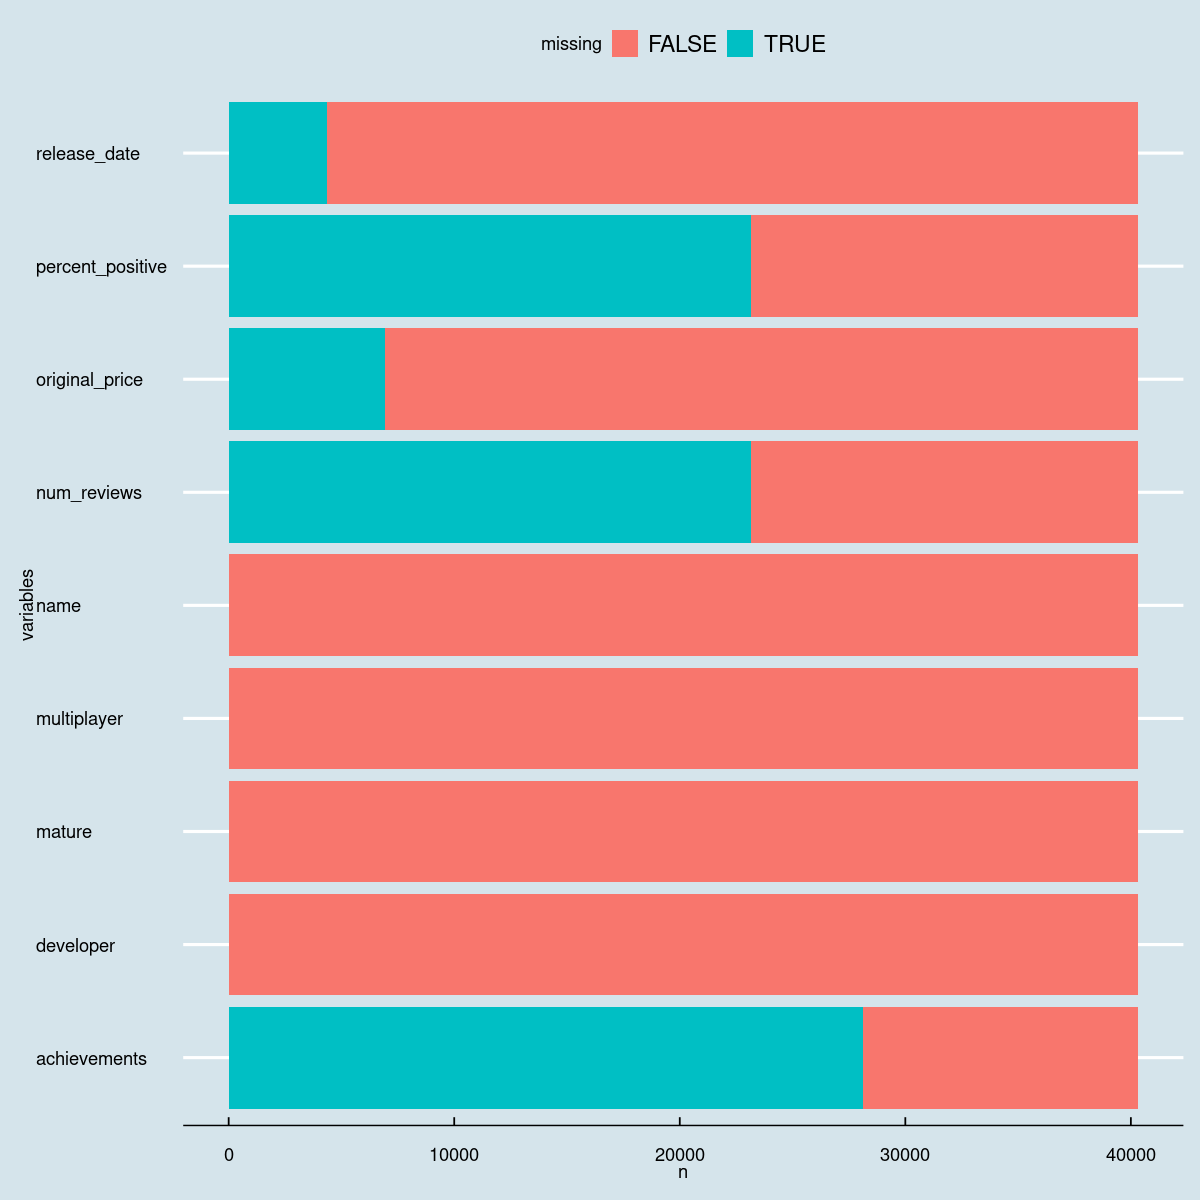

In [35]:
games  %>%
  summarise_all(list(~is.na(.)))%>%
  pivot_longer(everything(),
               names_to = "variables", values_to="missing") %>%
  count(variables, missing) %>%
  ggplot(aes(y=variables,x=n,fill=missing))+
  geom_col() + theme_economist()

The variable **achievement** has the highest number of missing values.



**Handling the missing data**
* Firstly, the missing values for the variable achievement will be replaced with zero value assuming that no achievements are offered to the players. The zero imputation will also apply for the variables number of reviews and percentage of positive reviews.

* For the rest of the variables with missing values, am going to remove the entire row.

In [ ]:
# Zero imputation
games$achievements[is.na(games$achievements)] <- 0
games$num_reviews[is.na(games$num_reviews)] <- 0
games$percent_positive[is.na(games$percent_positive)] <- 0

# removing the rows of the missing values for the remaining variables
games <- na.omit(games)

#Removing rows with blank values
games[!games$name=="",]
games[!games$developer==" ",]
games[!games$achievements==" ",]
games[!games$original_price==" ",]
games[!games$percent_positive==" ",]
games[!games$num_reviews==" ",]

dim(games) 

#Confirming
n_miss(games)


,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,DOOM,2016-05-12,id Software,54,19.99,92,42550,True,False
2,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,PUBG Corporation,37,29.99,49,836608,True,True
3,BATTLETECH,2018-04-24,Harebrained Schemes,128,39.99,71,7030,True,False
4,DayZ,2018-12-13,Bohemia Interactive,0,44.99,61,167115,True,False
5,EVE Online,2003-05-06,CCP,0,0.00,74,11481,True,False
7,Devil May Cry 5,2019-03-07,"CAPCOM Co., Ltd.",51,59.99,92,9645,True,True
8,Human: Fall Flat,2016-07-22,No Brakes Games,55,14.99,91,23763,True,False
9,They Are Billions,2017-12-12,Numantian Games,34,29.99,85,12127,False,False
10,Warhammer: Chaosbane,2019-05-31,Eko Software,43,49.99,44,904,True,True


,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,DOOM,2016-05-12,id Software,54,19.99,92,42550,True,False
2,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,PUBG Corporation,37,29.99,49,836608,True,True
3,BATTLETECH,2018-04-24,Harebrained Schemes,128,39.99,71,7030,True,False
4,DayZ,2018-12-13,Bohemia Interactive,0,44.99,61,167115,True,False
5,EVE Online,2003-05-06,CCP,0,0.00,74,11481,True,False
7,Devil May Cry 5,2019-03-07,"CAPCOM Co., Ltd.",51,59.99,92,9645,True,True
8,Human: Fall Flat,2016-07-22,No Brakes Games,55,14.99,91,23763,True,False
9,They Are Billions,2017-12-12,Numantian Games,34,29.99,85,12127,False,False
10,Warhammer: Chaosbane,2019-05-31,Eko Software,43,49.99,44,904,True,True


,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,DOOM,2016-05-12,id Software,54,19.99,92,42550,True,False
2,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,PUBG Corporation,37,29.99,49,836608,True,True
3,BATTLETECH,2018-04-24,Harebrained Schemes,128,39.99,71,7030,True,False
4,DayZ,2018-12-13,Bohemia Interactive,0,44.99,61,167115,True,False
5,EVE Online,2003-05-06,CCP,0,0.00,74,11481,True,False
7,Devil May Cry 5,2019-03-07,"CAPCOM Co., Ltd.",51,59.99,92,9645,True,True
8,Human: Fall Flat,2016-07-22,No Brakes Games,55,14.99,91,23763,True,False
9,They Are Billions,2017-12-12,Numantian Games,34,29.99,85,12127,False,False
10,Warhammer: Chaosbane,2019-05-31,Eko Software,43,49.99,44,904,True,True


,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,DOOM,2016-05-12,id Software,54,19.99,92,42550,True,False
2,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,PUBG Corporation,37,29.99,49,836608,True,True
3,BATTLETECH,2018-04-24,Harebrained Schemes,128,39.99,71,7030,True,False
4,DayZ,2018-12-13,Bohemia Interactive,0,44.99,61,167115,True,False
5,EVE Online,2003-05-06,CCP,0,0.00,74,11481,True,False
7,Devil May Cry 5,2019-03-07,"CAPCOM Co., Ltd.",51,59.99,92,9645,True,True
8,Human: Fall Flat,2016-07-22,No Brakes Games,55,14.99,91,23763,True,False
9,They Are Billions,2017-12-12,Numantian Games,34,29.99,85,12127,False,False
10,Warhammer: Chaosbane,2019-05-31,Eko Software,43,49.99,44,904,True,True


,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,DOOM,2016-05-12,id Software,54,19.99,92,42550,True,False
2,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,PUBG Corporation,37,29.99,49,836608,True,True
3,BATTLETECH,2018-04-24,Harebrained Schemes,128,39.99,71,7030,True,False
4,DayZ,2018-12-13,Bohemia Interactive,0,44.99,61,167115,True,False
5,EVE Online,2003-05-06,CCP,0,0.00,74,11481,True,False
7,Devil May Cry 5,2019-03-07,"CAPCOM Co., Ltd.",51,59.99,92,9645,True,True
8,Human: Fall Flat,2016-07-22,No Brakes Games,55,14.99,91,23763,True,False
9,They Are Billions,2017-12-12,Numantian Games,34,29.99,85,12127,False,False
10,Warhammer: Chaosbane,2019-05-31,Eko Software,43,49.99,44,904,True,True


,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,DOOM,2016-05-12,id Software,54,19.99,92,42550,True,False
2,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,PUBG Corporation,37,29.99,49,836608,True,True
3,BATTLETECH,2018-04-24,Harebrained Schemes,128,39.99,71,7030,True,False
4,DayZ,2018-12-13,Bohemia Interactive,0,44.99,61,167115,True,False
5,EVE Online,2003-05-06,CCP,0,0.00,74,11481,True,False
7,Devil May Cry 5,2019-03-07,"CAPCOM Co., Ltd.",51,59.99,92,9645,True,True
8,Human: Fall Flat,2016-07-22,No Brakes Games,55,14.99,91,23763,True,False
9,They Are Billions,2017-12-12,Numantian Games,34,29.99,85,12127,False,False
10,Warhammer: Chaosbane,2019-05-31,Eko Software,43,49.99,44,904,True,True


[1] 32724     9

[1] 0

### Summary Statistics

In [37]:
#Summary statistics of the numeric variables. 
describe(games[, c(4:7)])

# Dates of the oldest and latest release date 
paste0("The oldest video game  release date is ",  min(games$release_date))
paste0("The latest video game release date is ", max(games$release_date))



,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
achievements,1,32724,27.38580,272.4914,0.00,5.044538,0.0000,0,9821,9821,17.5899162,333.186626,1.5063283
original_price,2,32724,34.10724,3596.5257,4.99,7.254698,5.9304,0,650560,650560,180.8331030,32705.400762,19.8815377
percent_positive,3,32724,35.51201,39.6049,0.00,32.493086,0.0000,0,100,100,0.3529509,-1.679368,0.2189353
num_reviews,4,32724,555.68369,7293.8950,0.00,34.532429,0.0000,0,836608,836608,62.2551119,5886.157864,40.3205380


[1] "The oldest video game  release date is 1983-06-19"

[1] "The latest video game release date is 2023-12-25"

#### Categorical data Descriptive Statistics

Going to use one of the  most common forms of descriptive statistics for categorical data; **visualization**

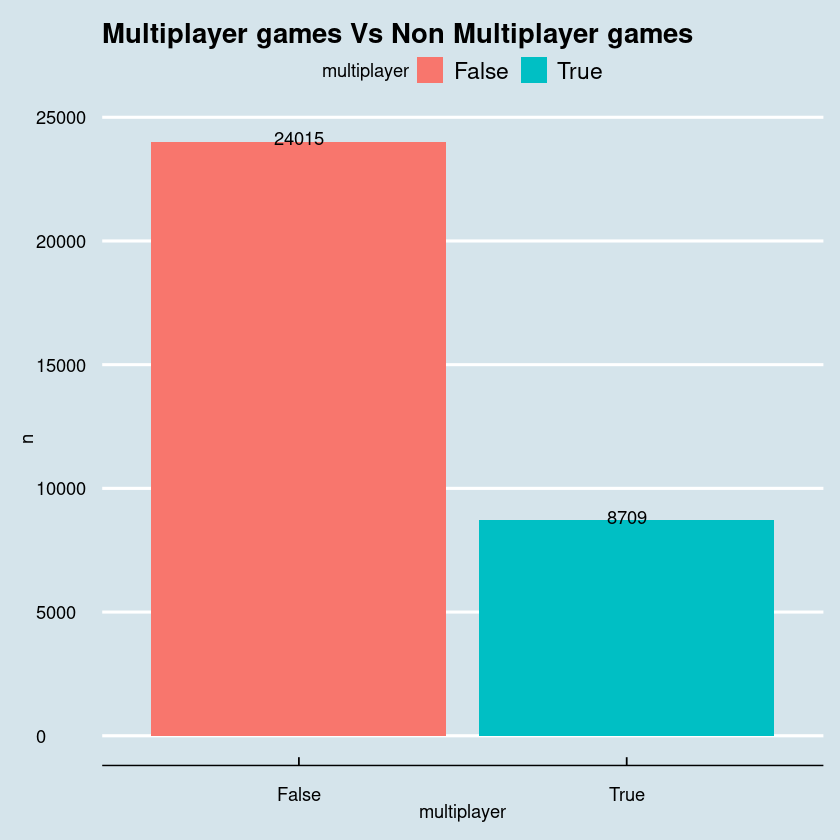

In [10]:
#Multiplayer
games %>% group_by(multiplayer) %>% summarise(n = n()) %>% ggplot(aes(multiplayer, n, fill = multiplayer)) + geom_col() + geom_text(aes(label = n), position = position_dodge(width = 1), vjust = 0.25) + theme_economist() + ggtitle("Multiplayer games Vs Non Multiplayer games")

There are less games that offer multiplayer option.

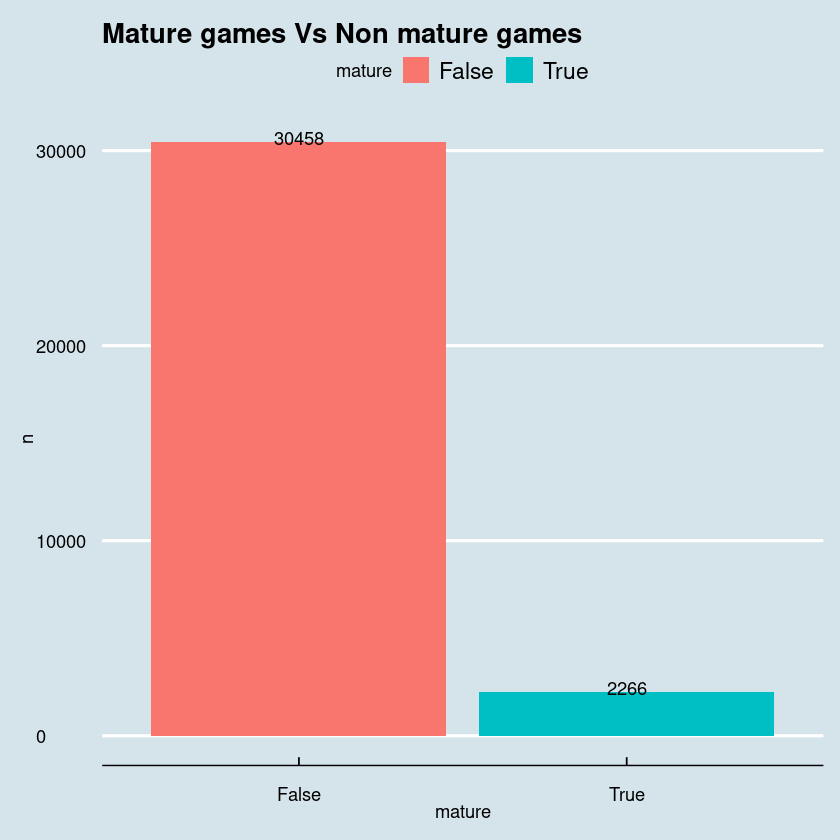

In [11]:
# mature 
games %>% group_by(mature) %>% summarise(n = n()) %>% ggplot(aes(mature, n, fill = mature)) + geom_col() + geom_text(aes(label = n), position = position_dodge(width = 1), vjust = 0.25) + theme_economist() + ggtitle("Mature games Vs Non mature games")

There are less games that have mature content.

#### Other Visualizations

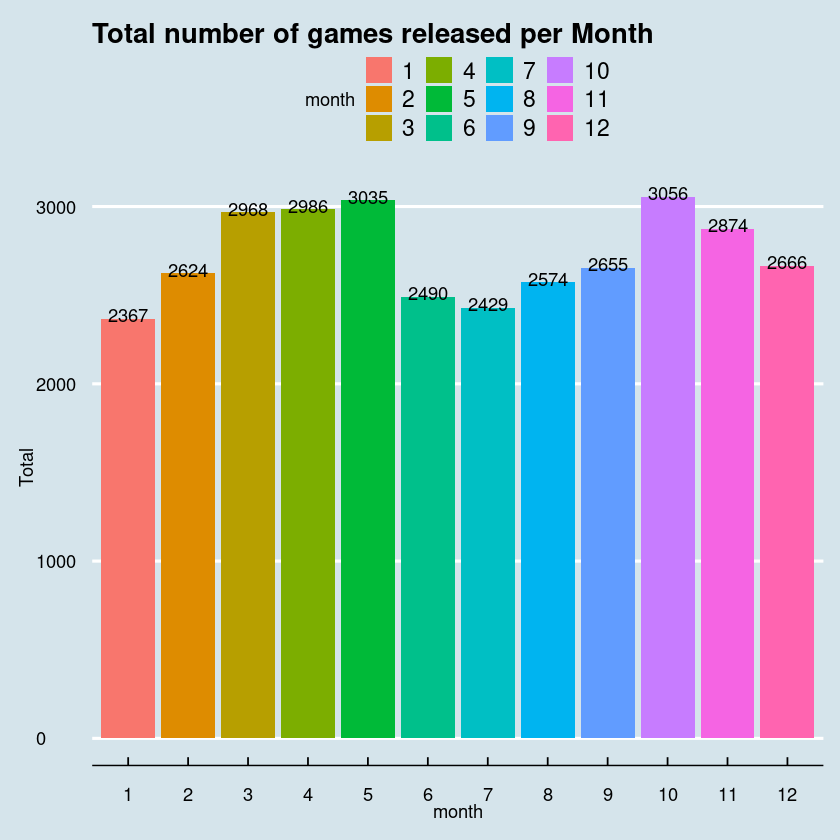

In [12]:
#Creating of factor of time object, year before plotting
games$month <- factor(month(games$release_date))

games_month <- games %>%
          group_by(month) %>%
             dplyr::summarize(Total = n())

ggplot(games_month, aes(month, Total, fill = month)) + 
        geom_bar( stat = "identity") +
           ggtitle("Total number of games released per Month") + theme_economist() + geom_text(aes(label = Total), position = position_dodge(width = 1), vjust = 0.25)


Most of the games are released on the month of October.

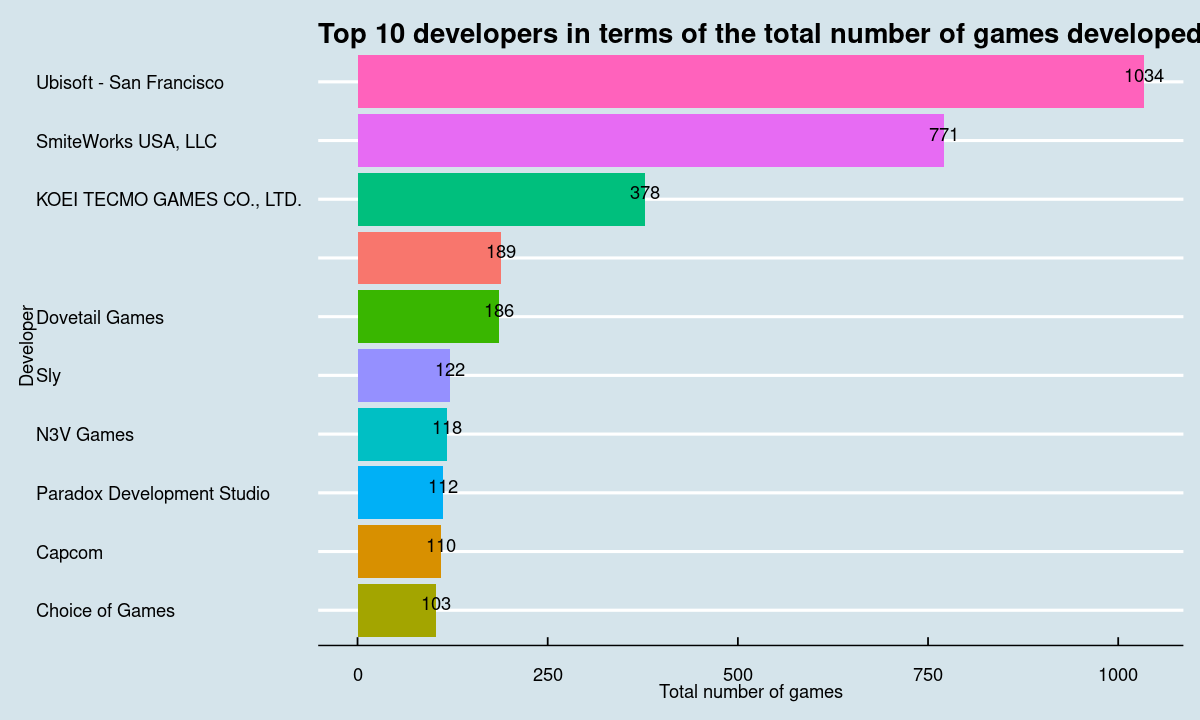

In [93]:
options(repr.plot.width = 10, repr.plot.height = 6)

#Plotting Top 10 developers in terms of the total number of games developed
games %>% group_by(developer) %>% dplyr::summarize(Total= n()) %>% top_n(10, Total) %>% ggplot(aes(x = reorder(developer, Total), y = Total, fill = developer)) + geom_col(show.legend = FALSE) + coord_flip() + geom_text(aes(label = Total), vjust = 0.01) + theme_economist() + ylab("Total number of games") + xlab("Developer") + ggtitle("Top 10 developers in terms of the total number of games developed")

Ubisoft- San Francisco takes the lead when it comes to the total number of games developed.

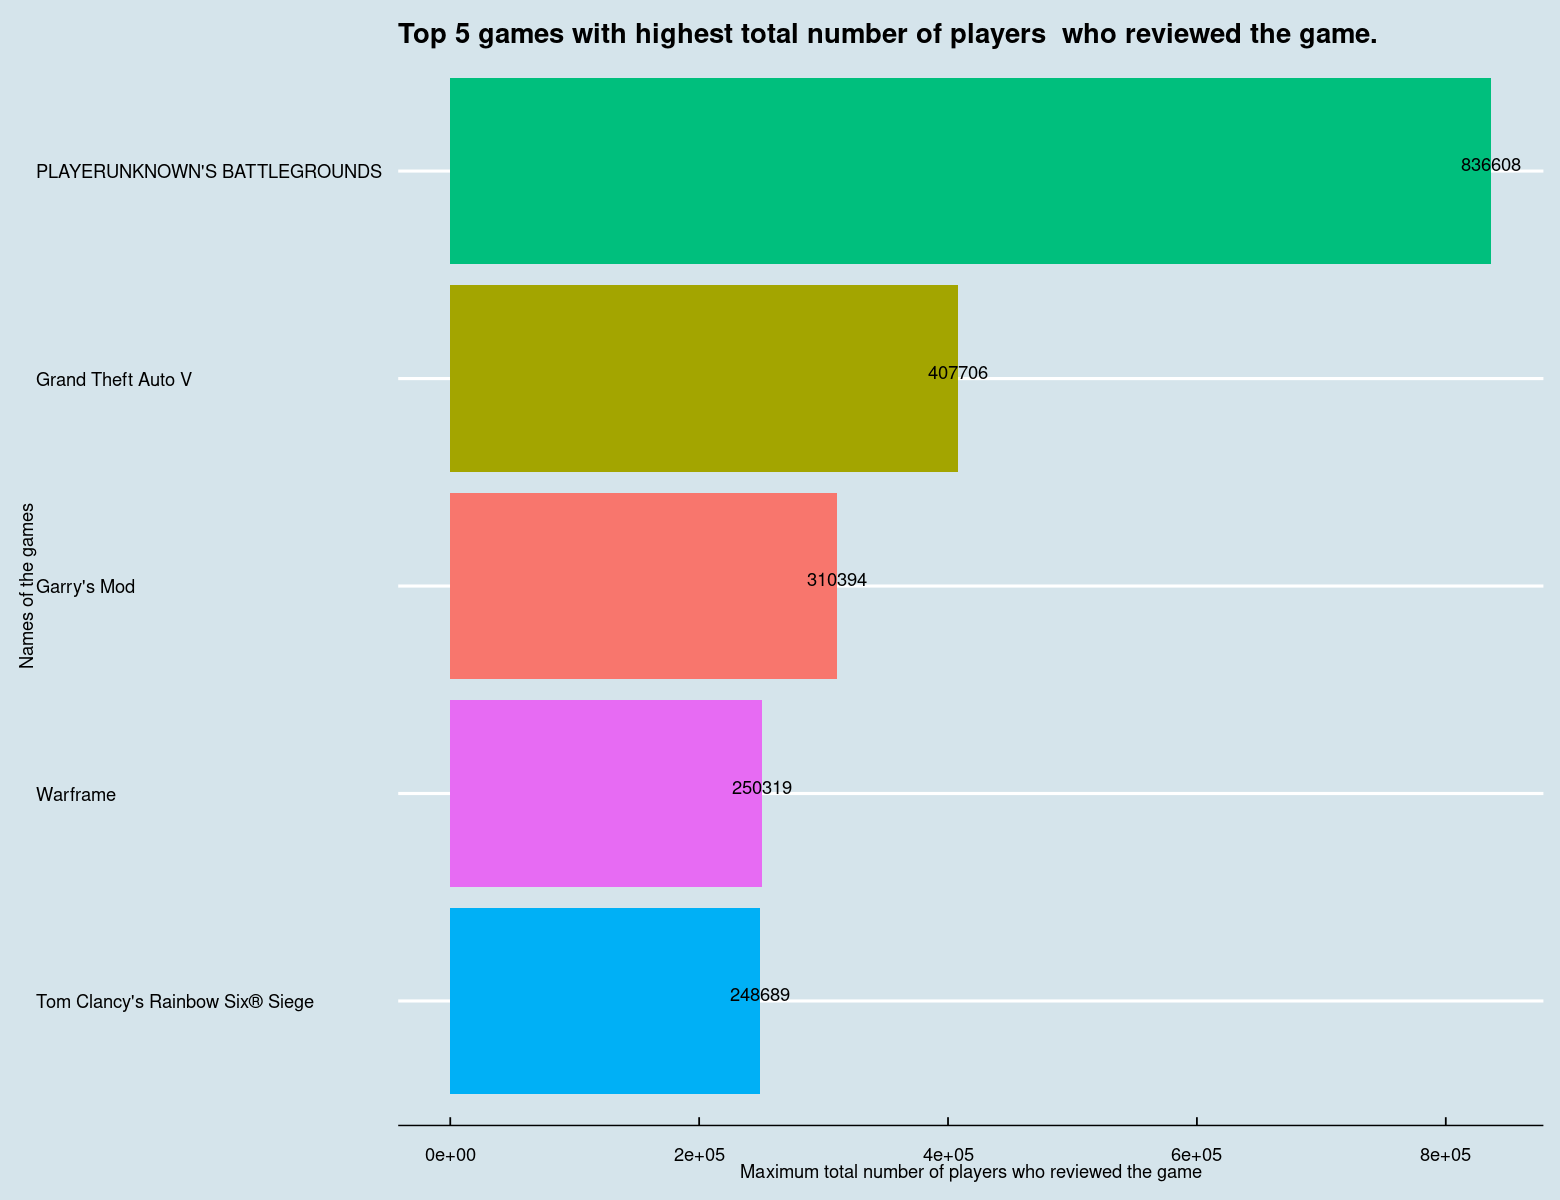

In [14]:
options(repr.plot.width = 13, repr.plot.height = 10)

#Top 5 games with highest  total number of players who reviewed the game.
games %>% group_by(name) %>% summarise(max_review = max(num_reviews)) %>% top_n(5, max_review) %>% ggplot(aes(x = reorder(name, max_review), y = max_review, fill = name)) + geom_col(show.legend = FALSE) + coord_flip() + geom_text(aes(label = max_review), vjust = 0.01) + theme_economist() + ylab("Maximum total number of players who reviewed the game") + xlab("Names of the games") + ggtitle("Top 5 games with highest total number of players  who reviewed the game.")

PLAYERUNKNOWN'S BATTLEGROUNDS has the highest total number of players who  reviewed it.

#### Correlation Plot

In [49]:
#making changes to the variables multiplayer and mature before plotting the correlation.
games <- games %>% mutate(multiplayer = case_when(multiplayer == "True" ~ 1,
                                                        multiplayer == "False" ~ 0))
games <- games %>% mutate(mature = case_when(mature == "True" ~ 1,
                                                             mature == "False" ~ 0))

Warning message in ggcorr(games[, -c(1:3)], name = "corr", label = TRUE):
“data in column(s) 'month' are not numeric and were ignored”


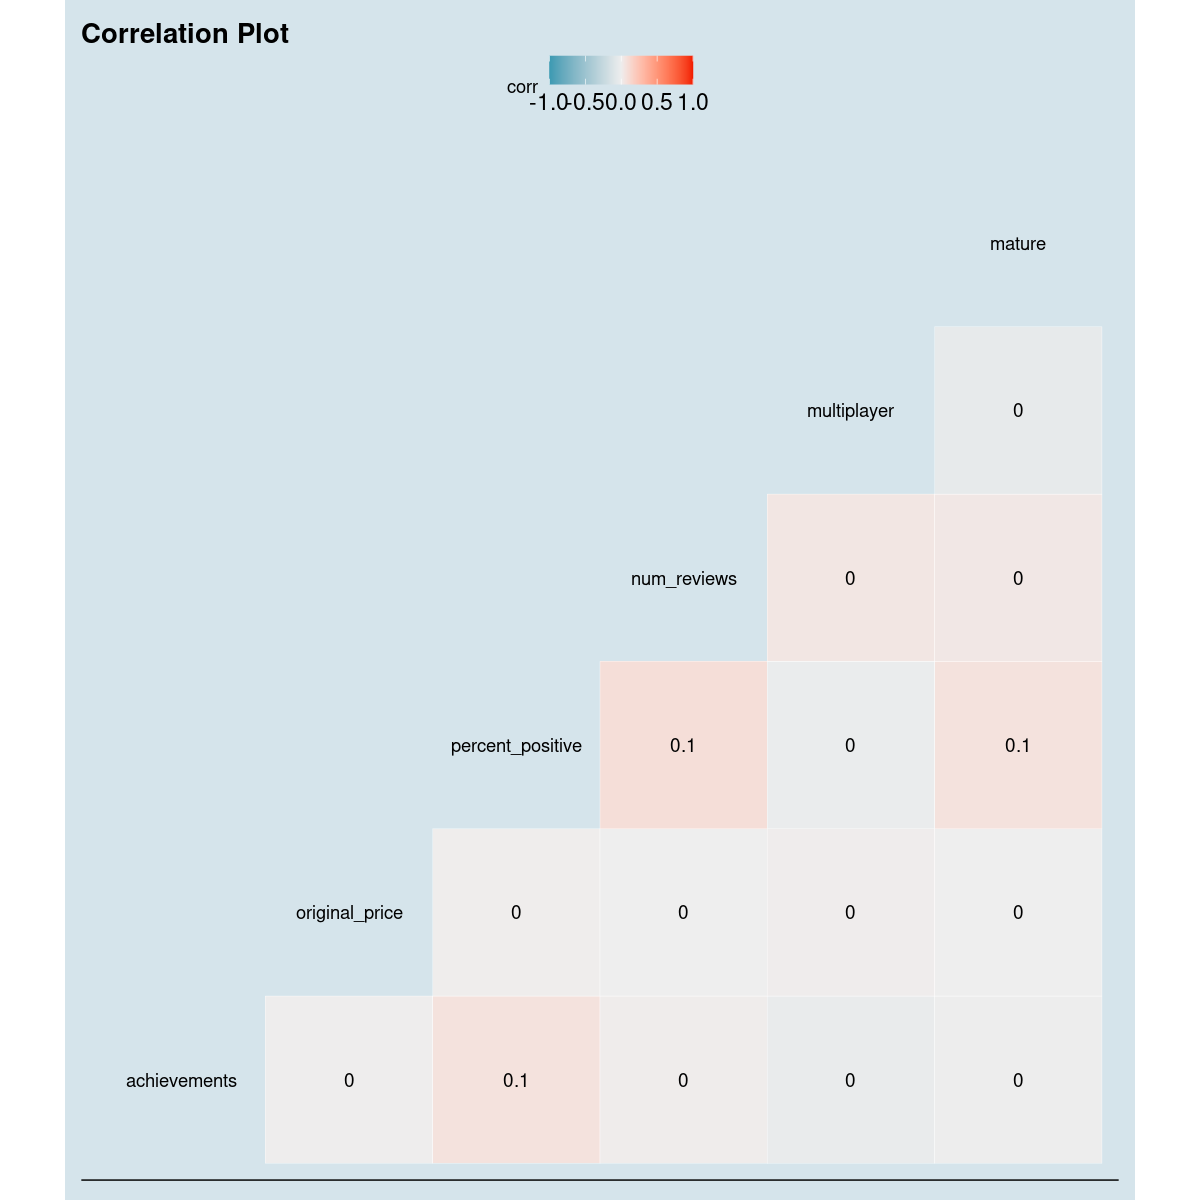

In [15]:
options(repr.plot.width = 10, repr.plot.height = 10)

# Plotting the correlation of the variables minus the outcome variable

ggcorr(games[, -c(1:3)], name = "corr", label = TRUE)+

  theme(legend.position="none")+

labs(title="Correlation Plot")+

theme(plot.title=element_text(face='bold',color='black',hjust=0.5,size=12)) + theme_economist()

There exists no relationship between majority of the pairs of variables.

In [50]:
#Making a copy of the cleaned data before proceeding.
games_copy <- games

## Cluster Analysis

Cluster analysis is used to find groups of observations (clusters) that share similar characteristics. Going to apply one of the commonly used clustering methods, **k-means clustering**. 

Before proceeding,  the summary statistics shows, the variables within this data are not comparable to one another and should be **scaled**. Then will implement k-means clustering, visualize and interpret the results. 

But first we will apply different methods that addresses the challenge of estimating **k** empirically from the data. These methods include:

* **The elbow method** - relies on calculating the total within cluster sum of squares across every cluster
* **Silhouette analysis**.

#### Standardization

In [16]:

#centering and scaling the data
Games <- scale(games[,c(4:9)], center = TRUE, scale = TRUE)


summary(Games)

  achievements      original_price      percent_positive   num_reviews       
 Min.   :-0.10050   Min.   : -0.00948   Min.   :-0.8967   Min.   : -0.07618  
 1st Qu.:-0.10050   1st Qu.: -0.00865   1st Qu.:-0.8967   1st Qu.: -0.07618  
 Median :-0.10050   Median : -0.00810   Median :-0.8967   Median : -0.07618  
 Mean   : 0.00000   Mean   :  0.00000   Mean   : 0.0000   Mean   :  0.00000  
 3rd Qu.:-0.05279   3rd Qu.: -0.00671   3rd Qu.: 1.0728   3rd Qu.: -0.06919  
 Max.   :35.94100   Max.   :180.87620   Max.   : 1.6283   Max.   :114.62357  
  multiplayer          mature       
 Min.   :-0.6022   Min.   :-0.2728  
 1st Qu.:-0.6022   1st Qu.:-0.2728  
 Median :-0.6022   Median :-0.2728  
 Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 1.6605   3rd Qu.:-0.2728  
 Max.   : 1.6605   Max.   : 3.6662  

The output shows that all the numerical variables have been standardized with mean value of ZERO

### 1. The elbow method

,k,tot_withinss
,<int>,<dbl>
1,1,196338.00
2,2,165471.00
3,3,140468.65
4,4,132407.09
5,5,82025.10
6,6,62992.31


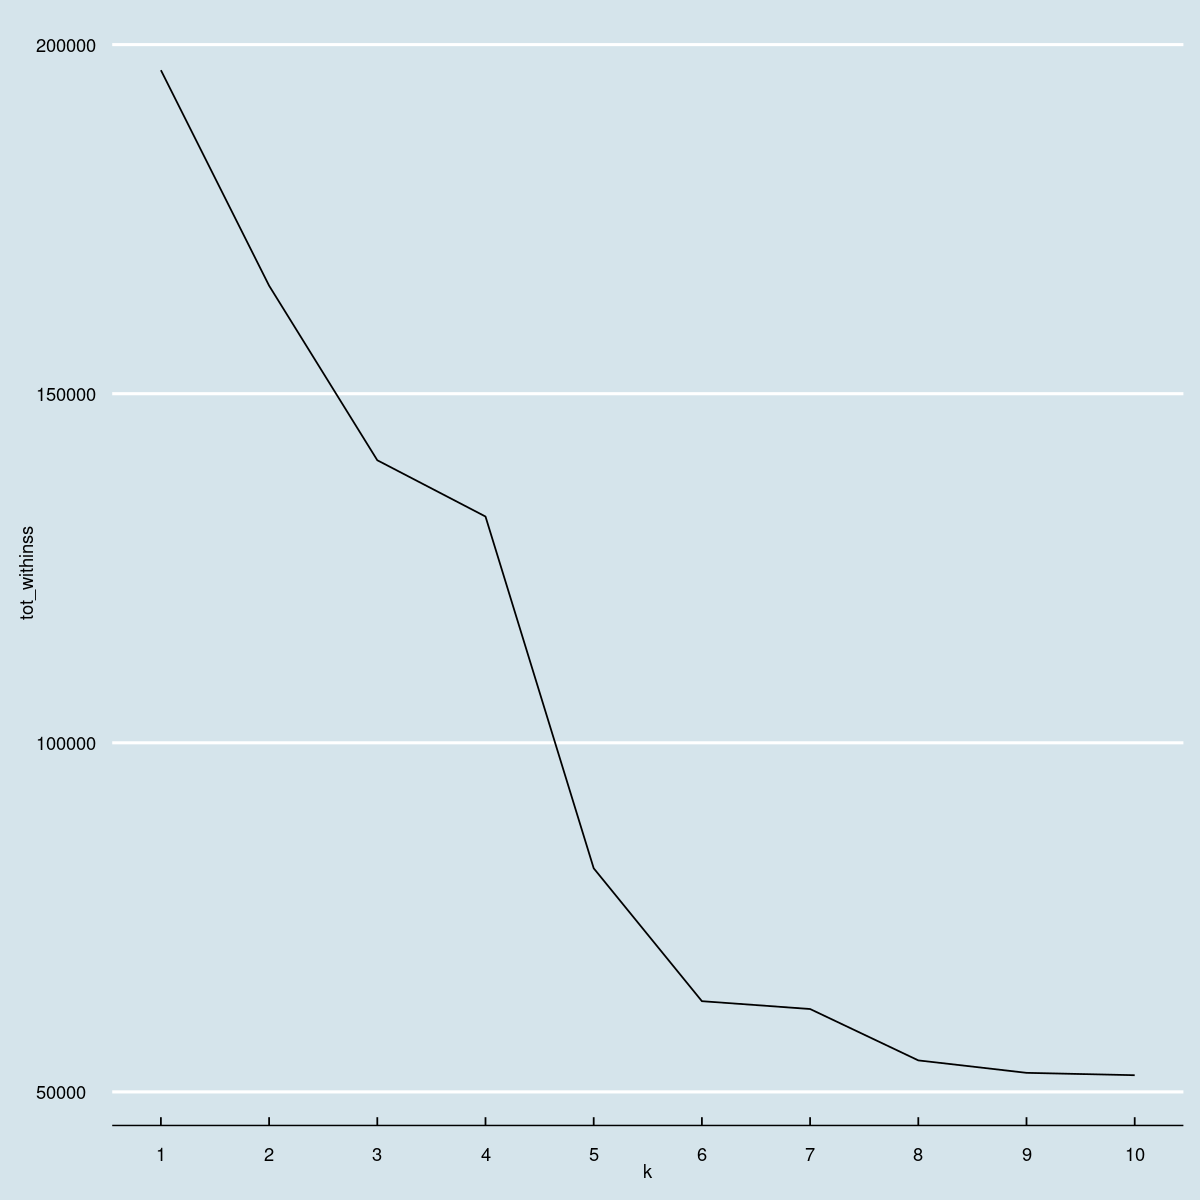

In [27]:
# Using map_dbl to run many models with varying value of k (centers). tot_withinss stands for total within-cluster sum of squares.
tot_withinss <- map_dbl(1:10, function(k){
  model <- kmeans(x = Games, centers = k)
  model$tot.withinss
})
# Generating a data frame containing both k and tot_withinss
elbow_df <- data.frame(
       k = 1:10,
       tot_withinss = tot_withinss)
head(elbow_df)

 #plotting the elbow plot
ggplot(elbow_df, aes(k, tot_withinss)) + geom_line() + scale_x_continuous(breaks = 1:10) + theme_economist()

The elbow method suggests  a k of **3**.

### 2. Silhouette analysis

This method provides a different lens through which you can understand the results of our cluster analysis. It can be used to determine how well each of our observations fit into its corresponding cluster and can be leveraged as an additional method for estimating the value of k

####  Average Silhouette Widths

The greater the average width the better the individual observations match to their clusters.

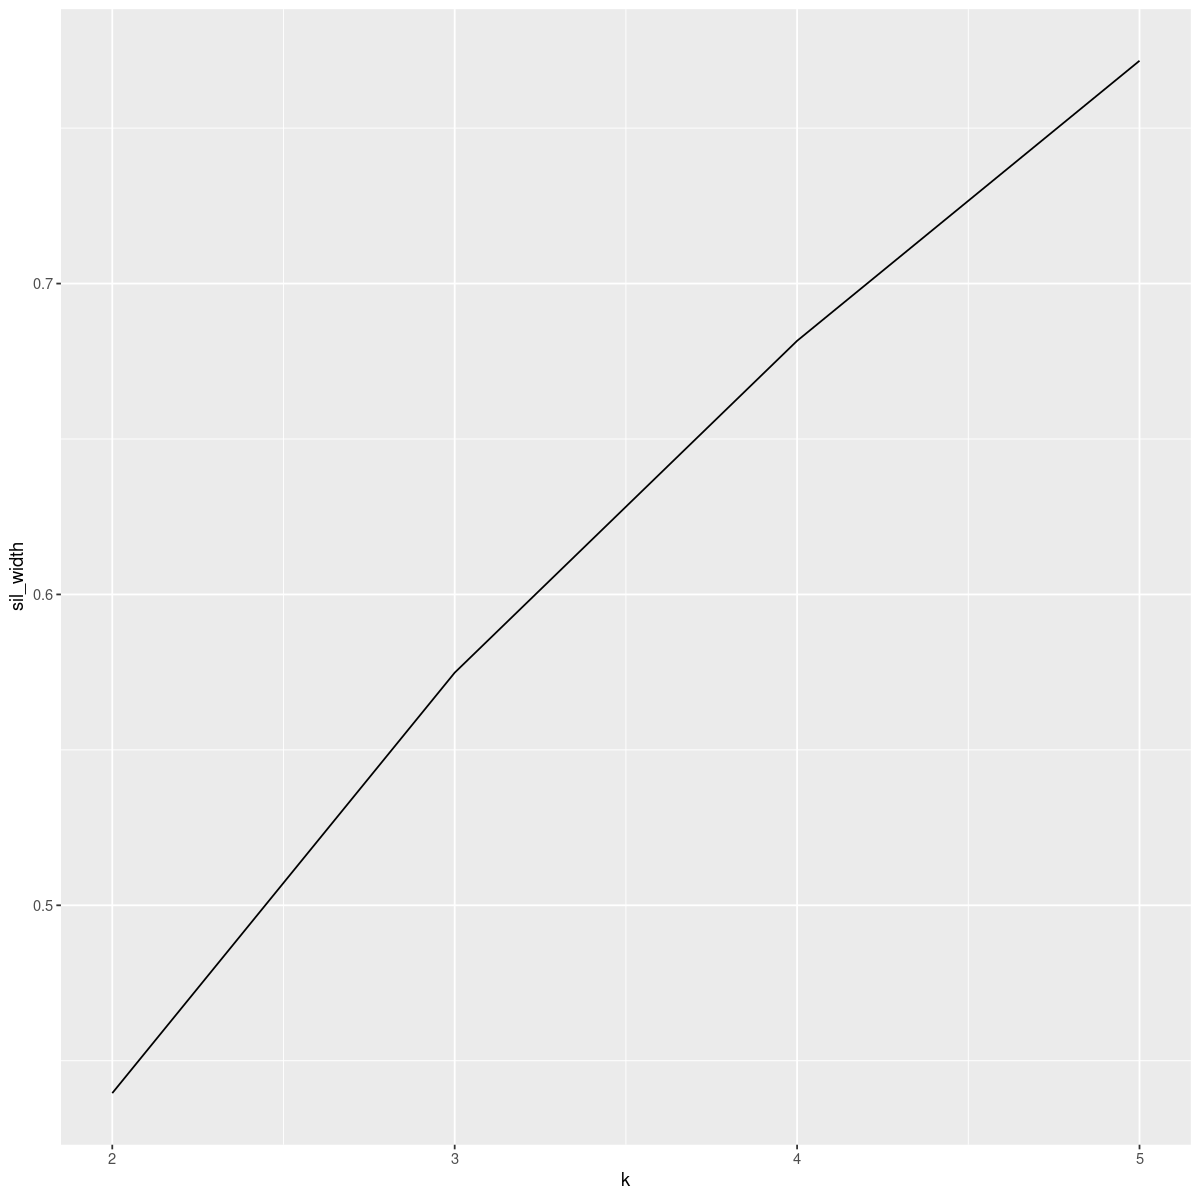

In [19]:
# Use map_dbl to run many models with varying value of k
sil_width <- map_dbl(2:5,  function(k){
  model <- pam(Games, k = k)
  model$silinfo$avg.width
})

# Generate a data frame containing both k and sil_width
sil_df <- data.frame(
  k = 2:5,
  sil_width = sil_width
)

# Plot the relationship between k and sil_width
ggplot(sil_df, aes(x = k, y = sil_width)) +
  geom_line() +
  scale_x_continuous(breaks = 2:5)

A k of  **5** has the largest Average Silhouette Widths

Going with the analysis of the clustering based on the elbow method of k = 3.

## Cluster Profiling

Now that we have formed the clusters let us look at there characteristics. For that, we will be profiling the clusters formed and come to a conclusion



In [54]:
set.seed(12345)

#Building a k-means model with a k of 3
games_md <- kmeans(games_copy[, -c(1:3)], center = 3)

#Extracting the vector of cluster assignment from the model
clust_games <- games_md$cluster

#Building the segment_games dataframe
segment_games <- mutate(games_copy[, -c(1:3)], cluster = clust_games)

#Calculating the mean for each category
count(segment_games, cluster)


#Adding the cluster variable to the original dataframe
games_copy <- games_copy %>% mutate(cluster = segment_games$cluster)


cluster,n
<int>,<int>
1,32630
2,84
3,10


* Cluster 1 consists of 32630 games
* Cluster 2 consists of 84 games.
* Cluster 3 consists of 10 games.

In [77]:
games_copy %>% group_by(cluster) %>% filter(achievements == 0) %>% count(achievements, sort = TRUE)

New names:
• `` -> `...1`


cluster,achievements,n
<int>,<dbl>,<int>
1,0,21285
2,0,14
3,0,1


In [84]:
games_copy %>% group_by(cluster) %>% filter(achievements  >= 5000) %>% count(achievements, sort = TRUE)

New names:
• `` -> `...1`


cluster,achievements,n
<int>,<dbl>,<int>
1,5000,68
1,9821,1


In [63]:
games_copy %>% count(cluster, multiplayer, sort = TRUE)

cluster,multiplayer,n
<int>,<dbl>,<int>
1,0,23970
1,1,8660
2,0,44
2,1,40
3,1,9
3,0,1


In [64]:
games_copy %>% count(cluster, mature, sort = TRUE)

cluster,mature,n
<int>,<dbl>,<int>
1,0,30376
1,1,2254
2,0,77
2,1,7
3,0,5
3,1,5


In [65]:
games_copy %>% group_by(cluster) %>% summarize(max_percent = max(percent_positive))

cluster,max_percent
<int>,<dbl>
1,100
2,98
3,97


In [92]:
games_copy %>% group_by(cluster) %>% filter(percent_positive == 0) %>% count()

New names:
• `` -> `...1`


cluster,n
<int>,<int>
1,17264


In [67]:
games_copy %>% group_by(cluster) %>% summarize(max_achievements = max(achievements))

cluster,max_achievements
<int>,<dbl>
1,9821
2,403
3,1130


In [68]:
games_copy %>% group_by(cluster) %>% summarize(max_price = max(original_price))

cluster,max_price
<int>,<dbl>
1,995.00
2,650560.00
3,39.99


In [87]:
games_copy %>% group_by(cluster) %>% filter(original_price == 0) %>% count()

New names:
• `` -> `...1`


cluster,n
<int>,<int>
1,1264
2,2


In [88]:

games_copy %>% group_by(cluster) %>% filter(num_reviews == 0) %>% count()

New names:
• `` -> `...1`


cluster,n
<int>,<int>
1,17251


In [89]:
games_copy %>% group_by(cluster) %>% summarize(max_reveiws = max(num_reviews))

cluster,max_reveiws
<int>,<dbl>
1,28513
2,168982
3,836608


### About the Clusters.

**Cluster 1**
* Have games that offer more than  or equal to 5000 achievements for player to earn.
* 3% of the games are free with the maximum price being less than 1000 dollars.
* 53% of the games have no positive reviews.
* There are lesser games that offer the option of multiplayer.
* There are lesser mature games.


**Cluster 2**
* 17% of the games in this group offer no achievements with the maximum achievements offered being less than 500.
* Highest Original  price of the game surpassing 500,000 dollars.(i.e 650560).
* Has second highest maximum number of reviews.
* Almost half of the games offer the multiplayer option.
* Majority of games are not of mature in nature.

**Cluster 3**
* 1 out of the 10 games offers no achievements to the players with the maximum number  offered being 1130.
* Original prices are below 50 dollars.
* Highest maximum number of reviews among the other clusters.
* 90% of the games offer multiplayer option.
* Half of the games are mature in nature.


## Conclusion

In this case study, I performed unsupervised clustering. I came up with 3 clusters and further used them in profiling  the games in clusters. This will assist in grouping into categories(clusters) based on the different game attributes so as to create new categories that help players find what they are looking for faster.

#### Recommendations for Future Work

The weaknesses and limitations of this clustering techniques developed in this research study has indicated the following area as recommendations for further work.
  * Interpretation of the clusters; comprehendable way of distinguishing the clusters after identification of the number of clusters.